#  Линейная и логистическая регрессии. #
Правило трех сигм. Облака рассеивания. Матрица ошибок. ROC-кривая.


Для выполнения задания я выбрала датасет **[Heart Attack Dataset](https://www.kaggle.com/datasets/sukhmandeepsinghbrar/heart-attack-dataset)** и задачу регрессии для прогнозирования состояния здоровья пациента (хорошее или плохое).

Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

Загружаем датасет

In [ ]:
data = pd.read_csv('https://drive.google.com/uc?id=10wg01xf1y_Z9DXpREmF8vm52WumqtKoC')
data.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,63,1,66,160,83,160.0,1.80,0.012,negative
1,20,1,94,98,46,296.0,6.75,1.060,positive
2,56,1,64,160,77,270.0,1.99,0.003,negative
3,66,1,70,120,55,270.0,13.87,0.122,positive
4,54,1,64,112,65,300.0,1.08,0.003,negative


Статистическое описание данных

In [ ]:
data.describe()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.193328,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.638173,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


**Предобработка**. Удалим дубликаты, переведем категориальные данные в количественные, а также проверим на наличие пустых значений в датасете.

In [ ]:
data = data.drop_duplicates()
data['Result'].replace(['negative', 'positive'], [0, 1], inplace=True)
data.isnull().values.any()

False

Пустых значений нет.

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Heart rate'}>],
       [<Axes: title={'center': 'Systolic blood pressure'}>,
        <Axes: title={'center': 'Diastolic blood pressure'}>,
        <Axes: title={'center': 'Blood sugar'}>],
       [<Axes: title={'center': 'CK-MB'}>,
        <Axes: title={'center': 'Troponin'}>,
        <Axes: title={'center': 'Result'}>]], dtype=object)

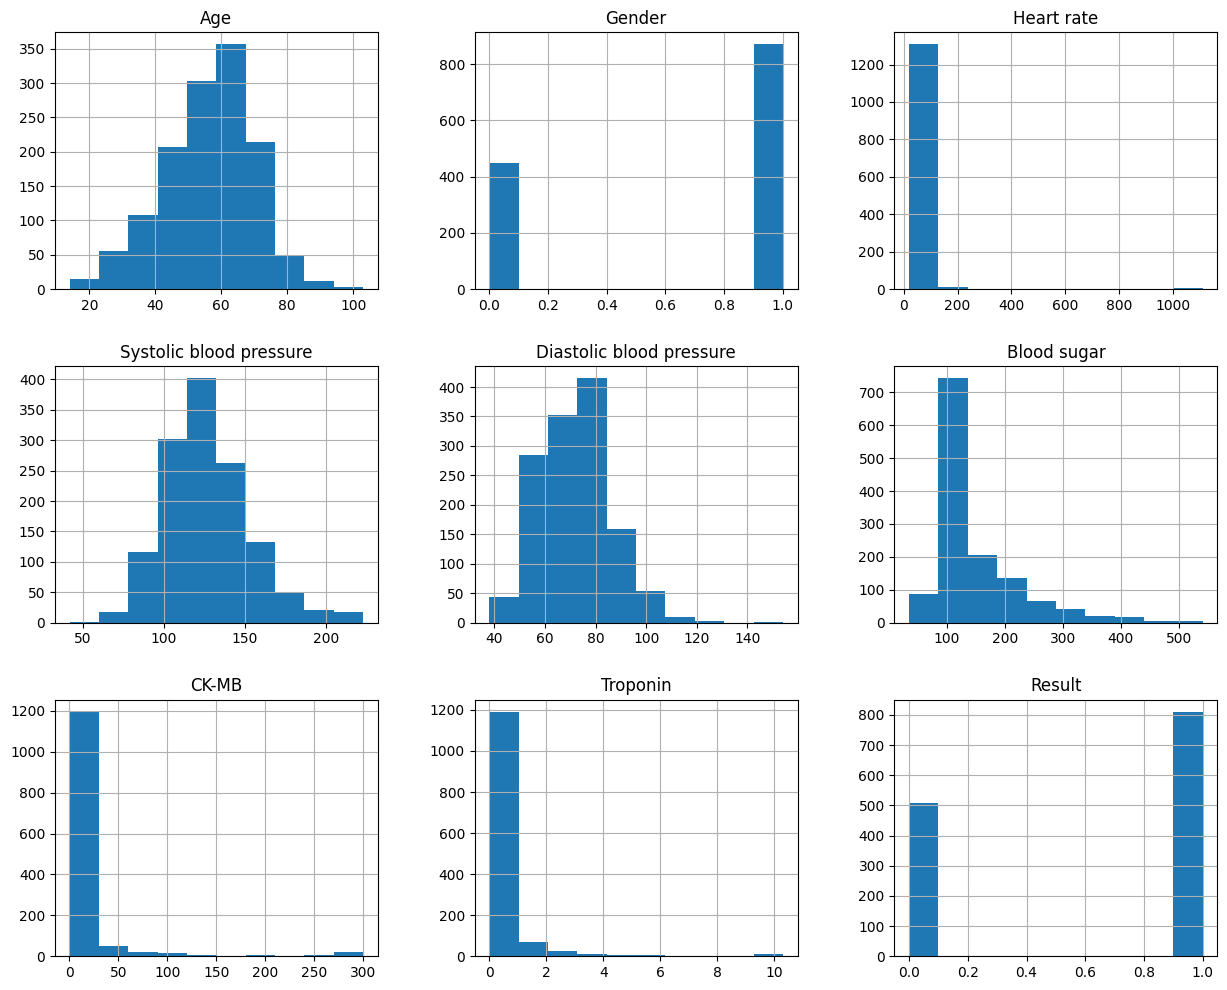

In [ ]:
data.hist(figsize=(15, 12))

В столбцах 'Gender' и 'Result' должны быть только 0 и 1. Проверим это:

In [ ]:
data['Gender'].unique()

array([1, 0])

In [ ]:
data['Result'].unique()

array([0, 1])

Разобьем датафрейм на 2 части: из категориальных признаков и численных. Обработаем вторую часть на выбросы.

In [ ]:
data_cat = data[['Gender', 'Result']] # категориальные признаки
data_num = data.drop(['Gender', 'Result'], axis=1) # численные признаки

Для удаления выбросов воспользуемся правилом трех сигм.

Определим, что такое сигма:

Стандартное отклонение (сигма) - корень из суммы квадратов разниц между элементами выборки и средним, деленной на количество элементов в выборке. Если количество элементов в выборке превышает 30, то знаменатель дроби под корнем принимает значение n-1.

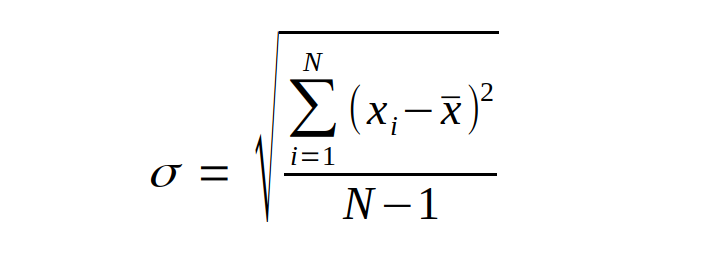

Правило:

Если случайная величина распределена нормально, то абсолютная величина ее отклонения от математического ожидания не превосходит утроенного среднего квадратического отклонения.
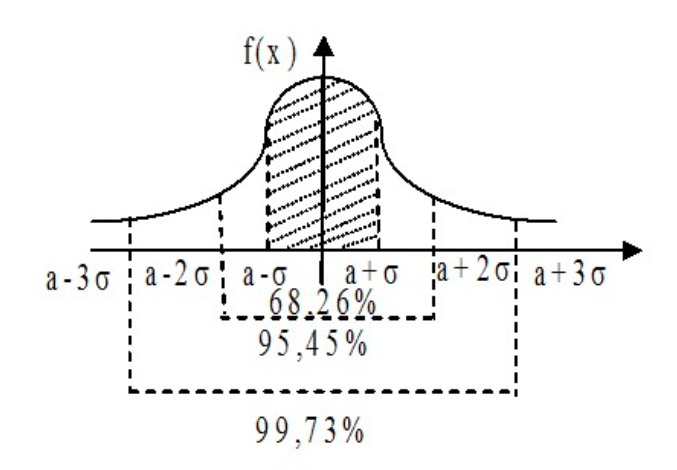

P(|X−a|<σ)=P(a−σ<X<σ+a)=0,6826

P(|X−a|<2σ)=P(a−2σ<X<2σ+a)=0,9545

P(|X−a|<3σ)=P(a−3σ<X<3σ+a)=0,9973

Функция определения выбросов

In [ ]:
def outlier_std(data, col, threshold=3):
  mean = data[col].mean()
  std = data[col].std() # сигма
  up = mean + threshold * std # верхняя грань
  low = mean - threshold * std # нижняя грань

  # все, что за пределами трех сигм - аномалия
  anomalies = pd.concat([data[col] > up, data[col] < low], axis=1).any(axis=1)
  return anomalies, up, low

In [ ]:
anomalies, up, low = outlier_std(data_num, data_num.columns)
anomalies

0       False
1       False
2       False
3       False
4       False
        ...  
1314    False
1315    False
1316     True
1317     True
1318    False
Length: 1319, dtype: bool

In [ ]:
up

Age                          97.107848
Heart rate                  233.227429
Systolic blood pressure     205.538745
Diastolic blood pressure    114.370916
Blood sugar                 371.403478
CK-MB                       154.255556
Troponin                      3.824645
dtype: float64

In [ ]:
low

Age                          15.278808
Heart rate                  -76.554191
Systolic blood pressure      48.802422
Diastolic blood pressure     30.167371
Blood sugar                 -78.134790
CK-MB                      -123.706944
Troponin                     -3.102761
dtype: float64

Функция вычисления статистики по аномалиям

In [ ]:
def get_column_outliers(data, func=outlier_std, threshold=3):
  # создание столбца - является ли значение выбросом
  outliers = pd.Series(data=[False]*len(data), index=data.index, name='is_outlier')

  comparison_table = {}

  # по каждому признаку
  for column in data.columns:
    anomalies, up, low = func(data, column, threshold=threshold)
    comparison_table[column] = [up, low, sum(anomalies), 100 * sum(anomalies)/len(anomalies)]
    outliers.loc[anomalies[anomalies].index] = True

  comparison_table = pd.DataFrame(comparison_table).T
  comparison_table.columns=['up', 'low', 'anomalies_count', 'anomalies_percentage']
  return comparison_table, outliers

In [ ]:
comparison_table, std_outliers = get_column_outliers(data_num)

comparison_table

,up,low,anomalies_count,anomalies_percentage
Age,97.107848,15.278808,4.0,0.303260
Heart rate,233.227429,-76.554191,3.0,0.227445
Systolic blood pressure,205.538745,48.802422,18.0,1.364670
Diastolic blood pressure,114.370916,30.167371,6.0,0.454890
Blood sugar,371.403478,-78.134790,31.0,2.350265
CK-MB,154.255556,-123.706944,37.0,2.805155
Troponin,3.824645,-3.102761,26.0,1.971190


In [ ]:
print(f"Total number of outliers: {sum(std_outliers)}\nPercentage of outliers {100 * sum(std_outliers)/len(std_outliers)}")

Total number of outliers: 114
Percentage of outliers 8.642911296436694


In [ ]:
data_num['is_outlier'] = std_outliers
data_num.head()

,Age,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,is_outlier
0,63,66,160,83,160.0,1.80,0.012,False
1,20,94,98,46,296.0,6.75,1.060,False
2,56,64,160,77,270.0,1.99,0.003,False
3,66,70,120,55,270.0,13.87,0.122,False
4,54,64,112,65,300.0,1.08,0.003,False


Изобразим облака рассеивания:

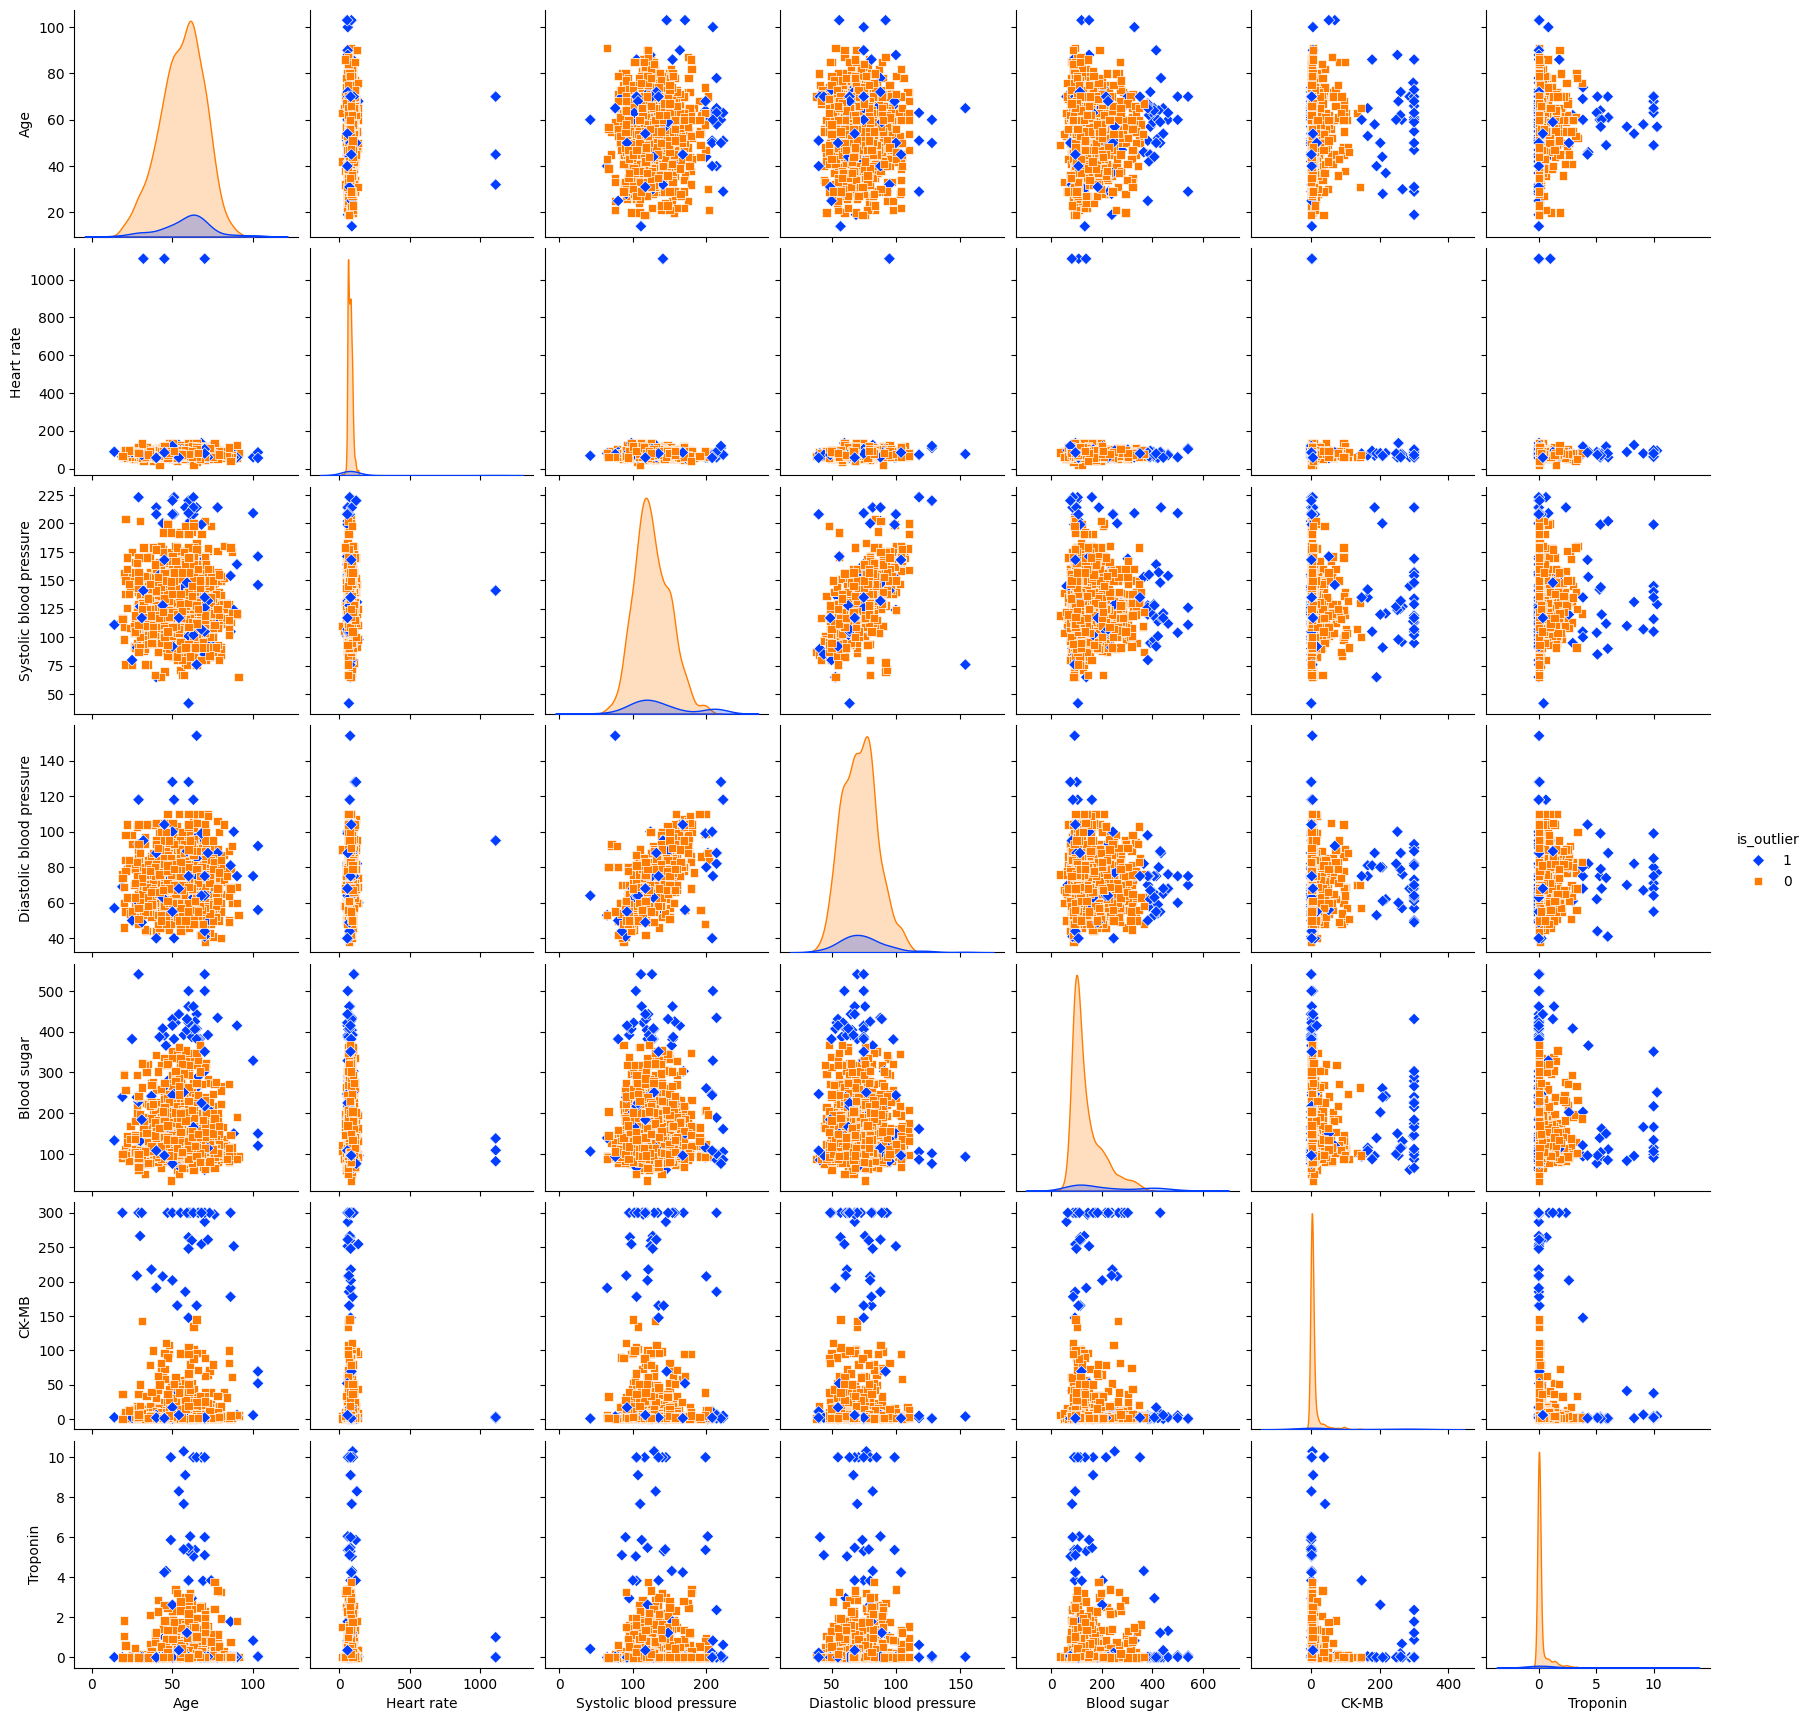

In [ ]:
sns.pairplot(data=data_num, vars=data_num.loc[:, data_num.columns != "is_outlier"].columns, hue='is_outlier', hue_order=[1, 0],
             markers=['s', 'D'], palette='bright');

По графикам видно, что больше всего выбросов по признаку 'CK-MB'. Это подтверждает [статистику](https://colab.research.google.com/drive/1nvRs3F0FDBSwwOZgchgg3l2cbp7qJ2Zj#scrollTo=fiAvHISg3us_&line=3&uniqifier=1).

Обратно склеиваем данные и удаляем выбросы.

In [ ]:
data = pd.concat([data_num, data_cat], axis=1)
data = data.loc[data['is_outlier'] != True]
data = data.drop(['is_outlier'], axis=1)
data

,Age,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Gender,Result
0,63,66,160,83,160.0,1.80,0.012,1,0
1,20,94,98,46,296.0,6.75,1.060,1,1
2,56,64,160,77,270.0,1.99,0.003,1,0
3,66,70,120,55,270.0,13.87,0.122,1,1
4,54,64,112,65,300.0,1.08,0.003,1,0
...,...,...,...,...,...,...,...,...,...
1312,48,84,118,68,96.0,5.33,0.006,1,0
1313,86,40,179,68,147.0,5.22,0.011,0,0
1314,44,94,122,67,204.0,1.63,0.006,1,0
1315,66,84,125,55,149.0,1.33,0.172,1,1


**Построение модели.** Делим выборку на обучающую и тестовую.

In [ ]:
X = data.drop(['Result'], axis=1)
X.insert(len(X.columns), "Free", [1 for i in range(len(X.index))], True)
Y = data['Result']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=1)

Сперва воспользуемся изученным на семинарах методом линейной регрессии.

Своя реализация

In [ ]:
X_train_T = np.transpose(X_train)
X_inv = np.linalg.inv(np.matmul(X_train_T, X_train))
X_pseudo = np.matmul(X_inv, X_train_T)

coef = np.matmul(X_pseudo, np.array([[i] for i in Y_train]))
pred = np.matmul(X_test.to_numpy(), coef.to_numpy()).transpose()[0]

print('MSE = ', mean_squared_error(Y_test,pred))
print('MAE = ', mean_absolute_error(Y_test,pred))

MSE =  0.18557846443879847
MAE =  0.40091006626375286


Функция построения графиков рапределения для сравнения тестовых и предсказанных значений.

In [ ]:
def compare_pred_real(Y_test, pred):
    # отрисовка
    compare = pd.DataFrame({'Real':Y_test,'Predicted':pred})
    compare.reset_index().drop('index',axis=1,inplace=True)

    plt.figure(figsize=(10,8))
    plt.xlabel('Comparison between Real and Predicted values ')
    a=sns.kdeplot(compare['Real'],fill=True,color='g')
    b=sns.kdeplot(compare['Predicted'],fill=True, color='b')
    plt.legend(labels=['Real','Predicted'])
    plt.show()

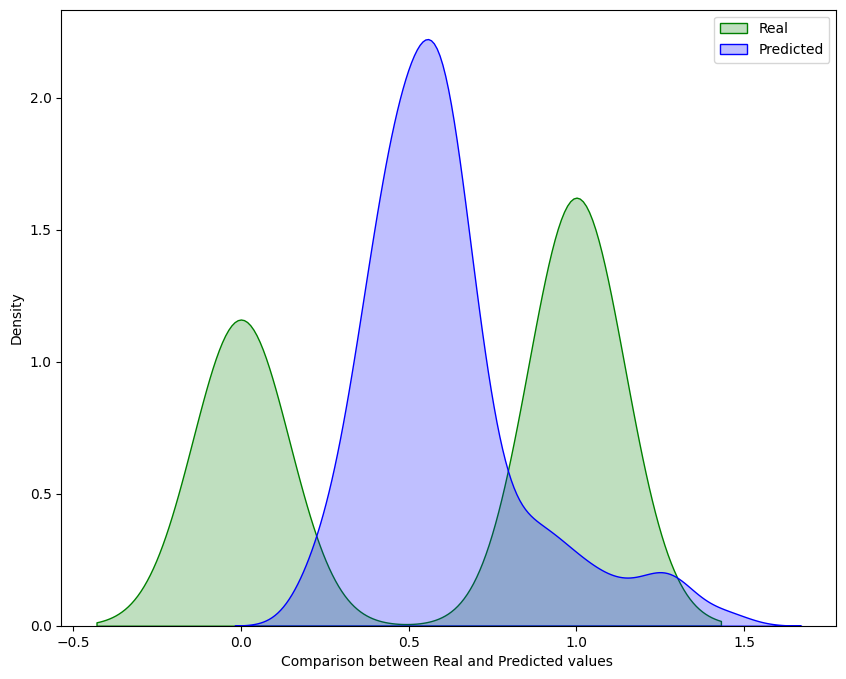

In [ ]:
compare_pred_real(Y_test, pred)

Готовыми функциями

MSE =  0.1855784644387983
MAE =  0.40091006626375264


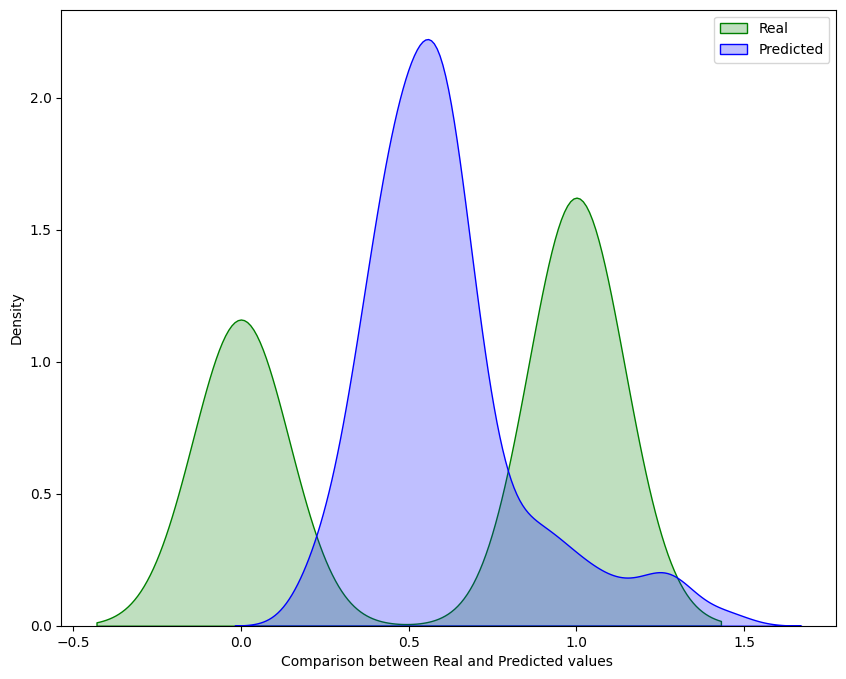

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
pred = lr.predict(X_test)

print('MSE = ', mean_squared_error(Y_test,pred))
print('MAE = ', mean_absolute_error(Y_test,pred))

compare_pred_real(Y_test, pred)

Получили одинаковые результаты.

Проанализируем графики. У зеленого графика есть два локальных максимума - в 0 и 1, это обусловлено тем, что результат был переведен из категориальных значений ('negative' и 'positive') в численные (0 и 1). Линейная регрессия предсказывает число, а не метку, поэтому предсказанные значения в основном лежат в промежутке [0, 1]. Так как значение функции, соответствующей зеленому графику, в 1 больше, чем в 0, абцисса экстремума синего графика смещена в сторону 1.

Попробуем округлить предсказанные значения

In [ ]:
pred = [round(p) for p in pred]

list(set(pred))

[0, 1]

При округлении получили значения, которые могут быть метками.

Без удаления выбросов построенная модель предсказывает значение 2 - для него нет категории. В таком случае можно округлять следующим образом:


```
pred = [1 if abs(p - 1) < abs (p) else 0 for p in pred]
```

In [ ]:
print('MSE = ', mean_squared_error(Y_test,pred))
print('MAE = ', mean_absolute_error(Y_test,pred))

MSE =  0.2551867219917012
MAE =  0.2551867219917012


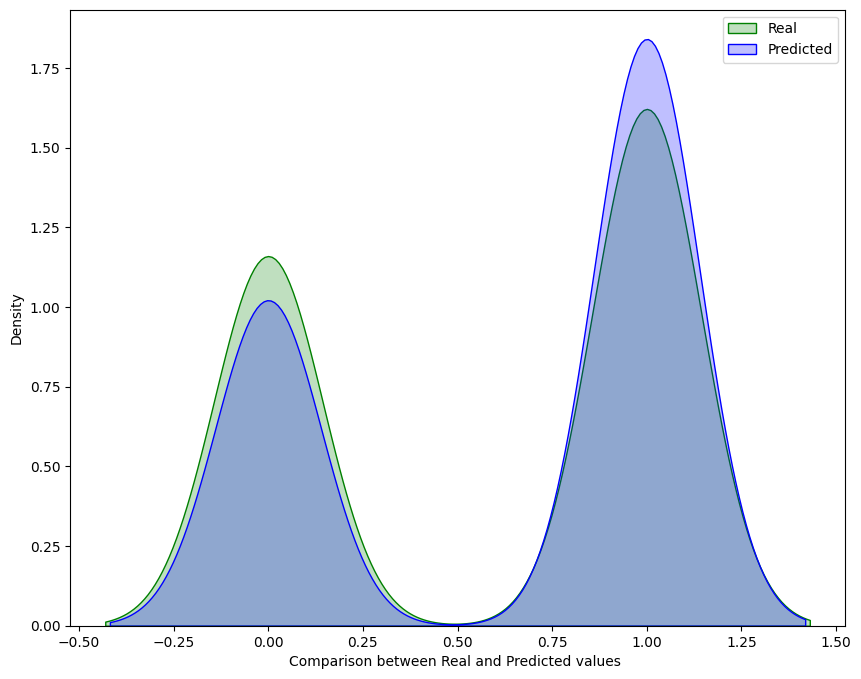

In [ ]:
compare_pred_real(Y_test, pred)

Теперь абциссы экстремумов для синего и зеленого графика стали совпадать, обработка значений прогнозирования привела к результату, который легче интерпретировать. По графику видно, что большая часть ошибок - предсказание 1 там, где должен быть 0.

Теперь можно переходить к оценке качества модели.

У нас есть 2 метки: [0, 1]. Одну из них считаем положительной - 1, вторую отрицательной - 0. Сравнивания предсказания с реальными значения есть 2 исхода: угадали или нет. Тогда всего для каждого значения существует 4 ситуации:


*   угадали положительному метку (true positive - TP)
*   не угадали положительную метку (false positive - FP)
*   угадали отрицательную метку (true negative - TN)
*   не угадали отрицательную метку (false negative - FN)

Удобно посчитать сколько значений относятся к каждой ситуации и по получившимся четырем числам построить матрицу ошибок.

Функция визуализации матрицы ошибок.

In [ ]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.PuRd):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # set matrix values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real')
    plt.xlabel('Predicted')
    plt.tight_layout()

Посчитаем точность модели - долю правильно предсказанных значений (отношение суммы значений на главной диагонали матрицы ошибок к сумме всех значений матрицы).

**Accuracy = (TP + TN) /(TP + TN + FP + FN)**

Функция описания модели.

In [ ]:
def model_desc(Y_test, pred):
    cnf_matrix = confusion_matrix(Y_test, pred)
    print("Confusion matrix:\n", cnf_matrix)
    print(f"true positive - {cnf_matrix[0][0]}\tfalse negative - {cnf_matrix[0][1]}\n\
false positive - {cnf_matrix[1][0]}\ttrue negative - {cnf_matrix[1][1]}")
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'])
    plt.show()
    print("Accuracy (from sklearn): ", accuracy_score(Y_test, pred))
    print("Accuracy (by the formula): ", np.trace(np.matrix(cnf_matrix)) / np.sum(cnf_matrix))

Confusion matrix:
 [[125  76]
 [ 47 234]]
true positive - 125	false negative - 76
false positive - 47	true negative - 234


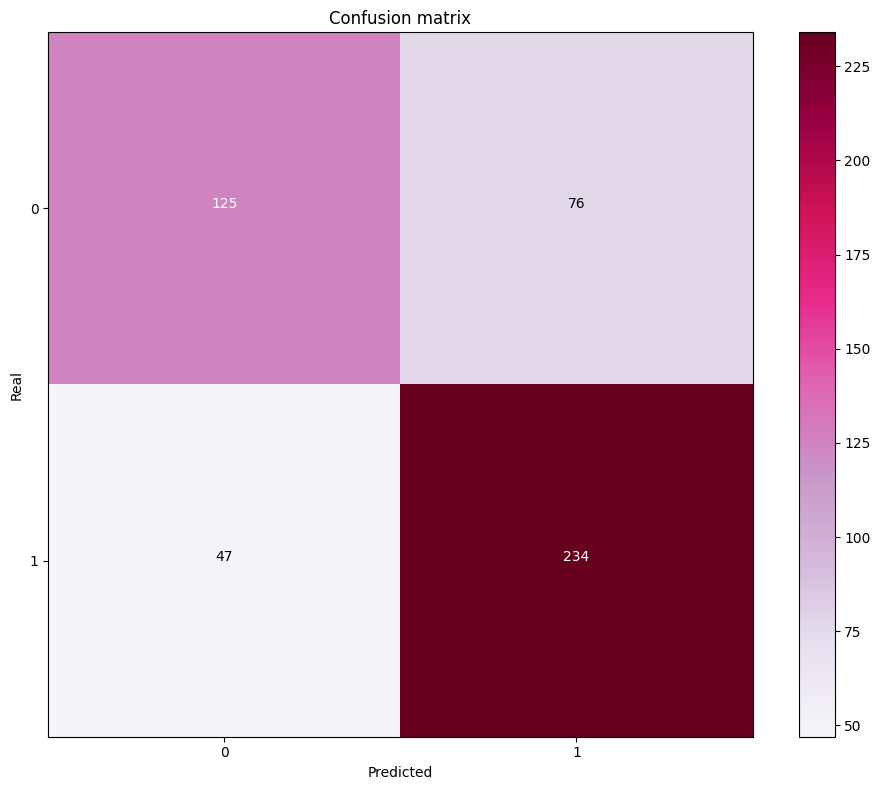

Accuracy (from sklearn):  0.7448132780082988
Accuracy (by the formula):  0.7448132780082988


In [ ]:
model_desc(Y_test, pred)

Для сравнения построим логистическую регрессию, которая сразу предсказывает результат из набора существующих меток.

MSE =  0.21991701244813278
MAE =  0.21991701244813278


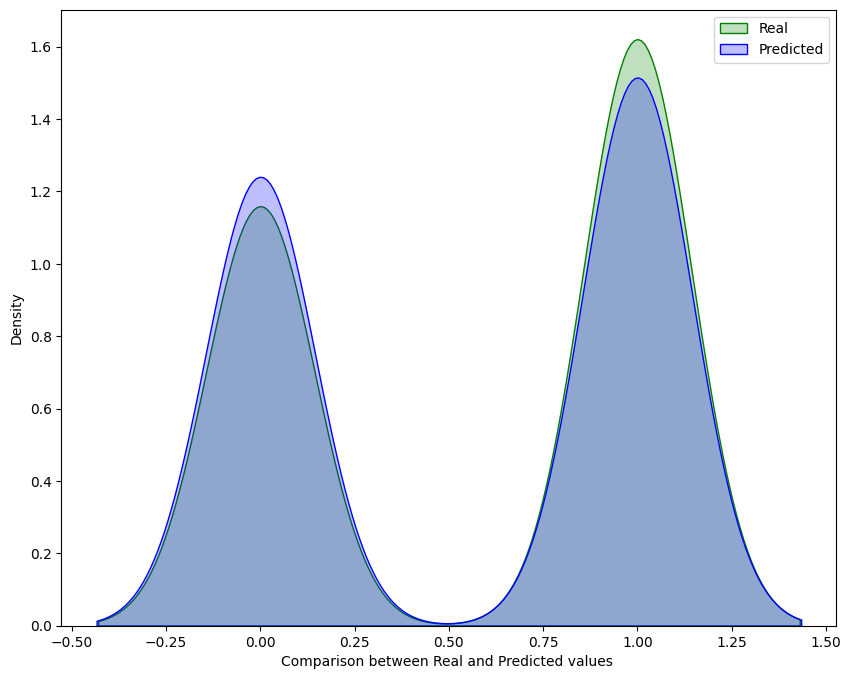

In [ ]:
log_re = LogisticRegression(solver='lbfgs', max_iter=1000)
log_re.fit(X_train, Y_train)
pred = log_re.predict(X_test)

print('MSE = ', mean_squared_error(Y_test, pred))
print('MAE = ', mean_absolute_error(Y_test, pred))

compare = pd.DataFrame({'Real':Y_test,'Predicted':pred})
compare.reset_index().drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,8))
plt.xlabel('Comparison between Real and Predicted values ')
a=sns.kdeplot(compare['Real'],fill=True,color='g')
b=sns.kdeplot(compare['Predicted'],fill=True, color='b')
plt.legend(labels=['Real','Predicted'])
plt.show()

Confusion matrix:
 [[156  45]
 [ 61 220]]
true positive - 156	false negative - 45
false positive - 61	true negative - 220


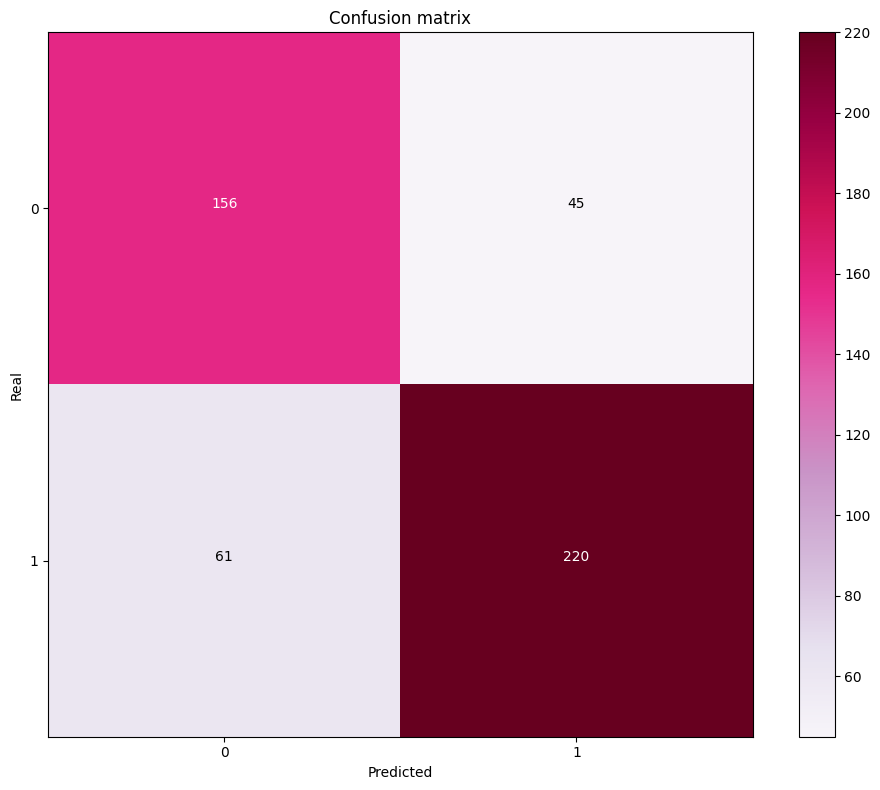

Accuracy (from sklearn):  0.7800829875518672
Accuracy (by the formula):  0.7800829875518672


In [ ]:
model_desc(Y_test, pred)

Исходя из полученных графиков, а также значений accuracy делаем вывод, что модель логистической регрессии лучше предсказывает значения. Продолжим работу с ней.

 Модель логистической регрессии возвращает оценку вероятности принадлежности примера к положительному классу. Метка присваивается, когда классификатор принимает значение, большее некоторого фиксированного порога. При уменьшении порога отсечения мы будем находить (правильно предсказывать) всё большее число положительных объектов, но также и неправильно предсказывать положительную метку на всё большем числе отрицательных объектов.

Построим ROC (Receiver Operating Characteristic)-кривую. Для этого необходимо ввести метрики True Positive Rate (TPR) и False Positive Rate (FPR).

TPR = TP / (TP + FN) - показывает, какой процент среди всех positive верно предсказан моделью

FPR = FP / (FP + TN) - показывает, какой процент среди всех negative неверно предсказан моделью

(их нельзя просто посчитать по матрице ошибок, поскольку они зависят от значения порога!)

Обе эти величины растут при уменьшении порога. Нужно балансировать между максимальным охватом TP случаев и минимизацией FP случаев.

ROC-кривая проходит через точки (0, 0) и (1, 1). При случайном распределении кривая представляет из себя прямую, а при идеальной модели она максимально приближена к точке (0, 1). Чем лучше разделяем два класса, тем больше площадь (area under curve) под ROC-кривой.

Оценивать модель можно по AUC. Эта площадь равна доле пар объектов вида (объект класса 1, объект класса 0), которые алгоритм правильно упорядочил (правильно предсказал класс для обоих объектов).

ROC AUC: 0.8771622315468918


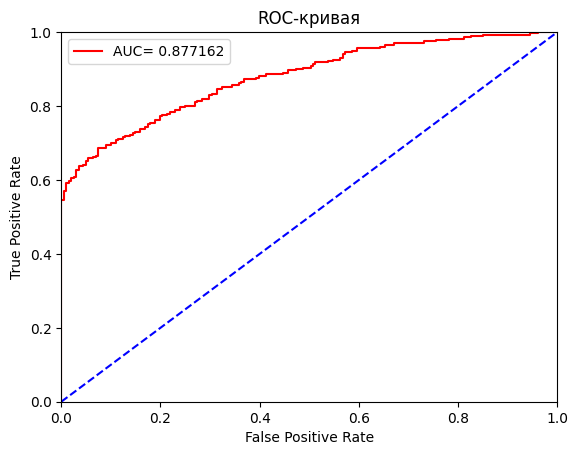

In [ ]:
lr_probs = log_re.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(Y_test, lr_probs)
print(f'ROC AUC: {lr_auc}')

fpr, tpr, treshold = roc_curve(Y_test, lr_probs)
plt.plot(fpr, tpr, label=f"AUC= {str(round(lr_auc, 6))}", color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

Значение AUC = 0.88 позволяет селать вывод, что нам удалось построить хорошую модель, для предсказания состояния здоровья пациента.